In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import ast
import string
import re
import plotly.express as px
import matplotlib.pyplot as plt
import nltk

In [264]:
form = pd.read_hdf("C:\\Users\\tommy\\OneDrive\\University\\Year 3\\Third Year Project\\Platform Album Data\\new_unigram_data.h5", key="reduced_music_form")
sentence = pd.read_hdf("C:\\Users\\tommy\\OneDrive\\University\\Year 3\\Third Year Project\\Platform Album Data\\new_unigram_data.h5", key="sentence")

In [3]:
# Get the text lists out of string format and into list representation
sentence.loc[:, "Text"] = sentence.loc[:, "Text"].apply(lambda x: ast.literal_eval(x))

In [4]:
# Explode to the sentence level
sentence = sentence.explode("Text")

In [5]:
# Get sentence ids
sentence["Sentence id"] = sentence.groupby("Review id").cumcount()

In [87]:
# Explode to the word level
word_sentence = sentence.explode("Text")
word_sentence = word_sentence.reset_index(drop=True)

In [88]:
# Get word ids
word_sentence["Word id"] = word_sentence.groupby("Review id").cumcount()

In [89]:
# Join to get desired words and corresponding sentence ids
word_sentence = pd.merge(word_sentence, form, on=["Artist", "Album", "Platform", "Review id", "Word id"], how="inner")

In [90]:
# Filter the dataframe to get only labelled reviews
word_sentence = word_sentence.loc[word_sentence["Review id"].isin(
    word_sentence.loc[word_sentence["Desired"] == 1, "Review id"].unique()
), :].reset_index(drop=True)

In [91]:
word_sentence.loc[:, "Desired"] = word_sentence.groupby(["Review id", "Sentence id"])["Desired"].transform(
    lambda x: 1 if any(x == 1) else -1)

In [106]:
tagging = word_sentence.groupby(["Review id", "Sentence id"])["Word"].apply(list).reset_index()
tags = tagging.loc[:, "Word"].apply(nltk.pos_tag).explode().apply(lambda x: x[1]).reset_index(drop=True)

In [108]:
word_sentence["tag"] = tags

In [139]:
tag_frequency = word_sentence.groupby(["Desired", "tag"]).size() / word_sentence.groupby(["Desired"]).size()
tag_frequency = tag_frequency.reset_index()
tag_frequency.loc[:, "Desired"] = tag_frequency.loc[:, "Desired"].apply(lambda x: True if x == 1 else False)

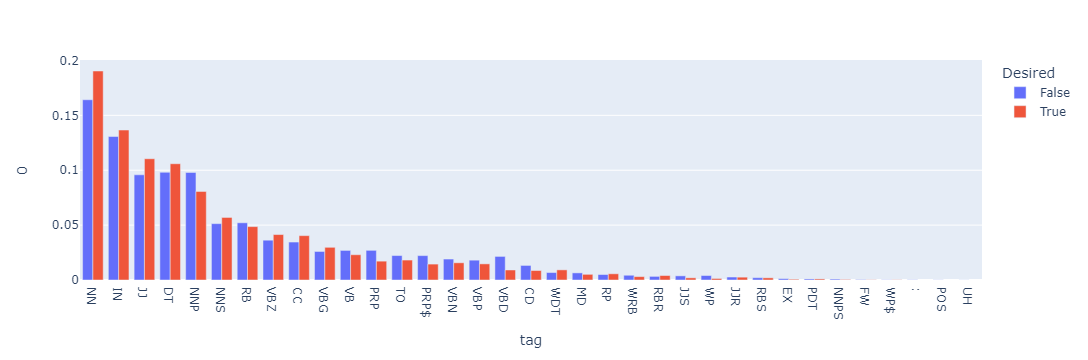

In [141]:
px.bar(tag_frequency, x="tag", y=0, color="Desired", barmode="group").update_xaxes(categoryorder="total descending")

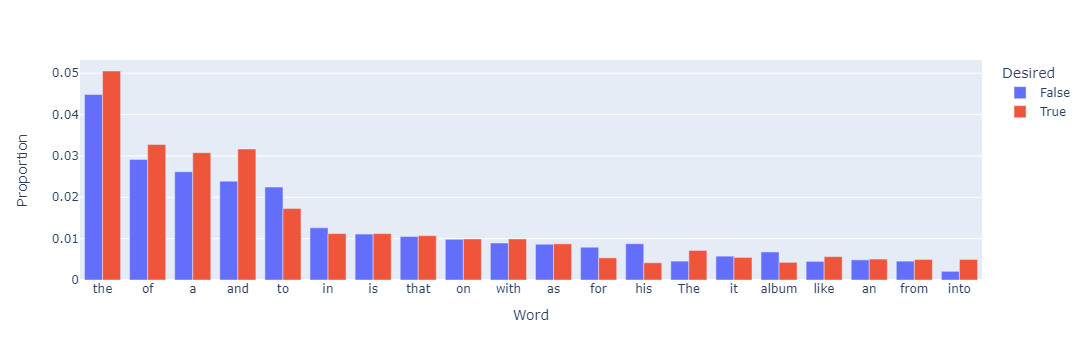

In [153]:
word_frequency = word_sentence.groupby(["Desired", "Word"]).size() / word_sentence.groupby(["Desired"]).size()
word_frequency = word_frequency.reset_index().rename({0: "Proportion"}, axis=1)
word_frequency.sort_values(by="Proportion", ascending=False)
word_frequency = word_frequency.loc[word_frequency["Word"].isin(
    word_frequency.loc[word_frequency["Desired"] == 1].sort_values(by="Proportion", ascending=False).head(20).loc[:, "Word"])]
word_frequency.loc[:, "Desired"] = word_frequency.loc[:, "Desired"].apply(lambda x: True if x == 1 else False)
px.bar(word_frequency, x="Word", y="Proportion", color="Desired", barmode="group").update_xaxes(categoryorder="total descending")

In [253]:
word_ratio = word_sentence.groupby(["Desired", "Word"]).size().div(word_sentence.groupby(["Desired"]).size()).reset_index().rename(
    {0: "Proportion"}, axis=1)
word_ratio.loc[:, "Desired"] = word_ratio.loc[:, "Desired"].apply(lambda x: True if x == 1 else False)
word_ratio = word_ratio.pivot(index="Word", columns="Desired", values="Proportion").rename({True: "True", False: "False"}, axis=1)
word_ratio = word_ratio.loc[:, "True"].div(word_ratio.loc[:, "False"]).reset_index().rename({0: "Ratio"}, axis=1)

In [260]:
word_ratio.sort_values(by="Ratio", ascending=False).head(30)

,Word,Ratio
1844,bass,24.800476
4048,jazz,18.187016
5544,riff,14.880286
1489,acoustic,11.573556
5429,releases,11.573556
2487,country,9.920191
6573,tune,9.920191
1864,beats,9.920191
5723,set,9.920191
2871,drum,9.920191


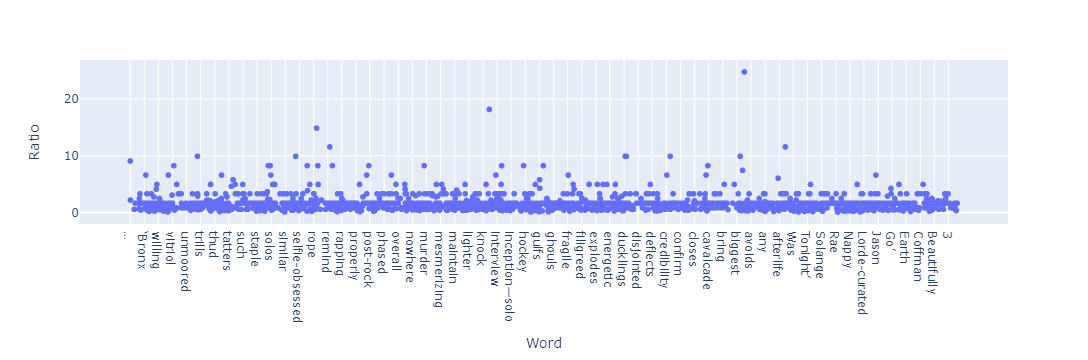